# Detector Response Files
The GBM detector response files allow you to compare a theoretical photon spectrum to an observed count spectrum.  In short, a single detector response file is only useful for its corresponding detector, for a given source position on the sky, and a given time (or relatively short time span).  Essentially one file contains one or more detector response matrices (DRMs) encoding the energy dispersion and calibration of incoming photons at different energies to recorded energy channels.  The matrix also encodes the effective area of the detector as a function of energy for a given source position relative to the detector pointing.  This effective area can change dramatically as there is a strong angular-dependence of the response (and the angular-dependence changes with energy!).  A file that contains a single DRM will be named with a '.rsp' extension, and a file containing more than one DRM will be named with a '.rsp2' extension.  The rsp2 files typically have a DRM generated for every *x* degrees of spacecraft slew relative to the source, useful for studying the spectrum of transients that may be several tens or hundreds of seconds long (and therefore the detector pointing is changing singificantly relative to the source).

Similar to the science data, we can open/read a response file in the following way:

In [1]:
from gbm import test_data_dir
from gbm.data import RSP
rsp = RSP.open(test_data_dir+'/glg_cspec_n4_bn120415958_v00.rsp2')
print(rsp)

glg_cspec_n4_bn120415958_v00.rsp2


You can see all the metadata in the FITS headers:

In [2]:
rsp.headers.keys()

odict_keys(['PRIMARY', 'EBOUNDS', 'SPECRESP MATRIX1', 'SPECRESP MATRIX2', 'SPECRESP MATRIX3', 'SPECRESP MATRIX4', 'SPECRESP MATRIX5', 'SPECRESP MATRIX6', 'SPECRESP MATRIX7', 'SPECRESP MATRIX8', 'SPECRESP MATRIX9', 'SPECRESP MATRIX10', 'SPECRESP MATRIX11', 'SPECRESP MATRIX12'])

In [3]:
rsp.headers['PRIMARY']

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = './SA_GBM_RSP_Gen.pl-1.11  GBMRSP V1.9' / Program creating this file  
FILETYPE= 'GBM DRM '                                                            
FILE-VER= '1.0.0   '           / Version of FITS file format                    
DATE    = '2012-04-16T02:43:57' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
FILENAME= 'glg_cspec_n4_bn120415958_v00.rsp2' / Name of FITS file               
DATE-OBS= '2012-04-15T22:57:12' / YYYY.DDD at start of data                     
DATE-END= '2012-04-15T23:07:

You probably noticed all the "SPECRESP MATRIXn" headers in the header listing.  This is an rsp2 file, so there are multiple DRMs contained.  We can easily determine how many matrices are contained (without having to count the header extensions):

In [4]:
rsp.numdrms

12

Other important attributes that we might need to know are the number of photon bins (the energy of the incoming photons) and the number of energy channels:

In [5]:
print('Number of energy channels: {}'.format(rsp.numchans))
print('Number of photon bins: {}'.format(rsp.numebins))

Number of energy channels: 128
Number of photon bins: 140


An rsp2 file containing multiple DRMs indicates there is a DRM that is most appropriate to use for a given time.  You can find the DRM that is closest to your time of interest:

In [6]:
# return the DRM closest to trigger time
drm = rsp.nearest_drm(0.0)

Or maybe you are interested in which DRMs cover a time range of interest and retrieve those DRMs:

In [7]:
# which drms cover the time range
drm_indices = rsp.drm_index((0.0, 20.0))
drms = [rsp.drm(drm_index) for drm_index in drm_indices]

What does a DRM actually look like, btw?  You can make a plot of one using the ```ResponseMatrix``` class in the ```gbm.plot``` module:

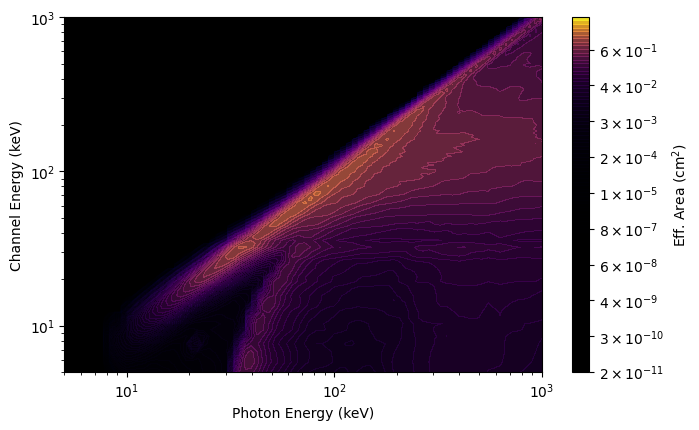

In [8]:
%matplotlib inline
from gbm.plot import ResponseMatrix

rsp_plot = ResponseMatrix()
rsp_plot.set_response(rsp, color='plasma') # a pretty color gradient
rsp_plot.xlim = (5.0, 1000.0)
rsp_plot.ylim = (5.0, 1000.0)

What you see in the plot is a diagonal edge that contains a majority of the effective area.  This approximately linear mapping of photon energy to energy channel is called the **photopeak**.  You also see a bunch of off-diagonal contribution from photons deposited into energy channels lower than the original photon energy.  This presence of non-negligible off-diagonal response is one of the reasons that the DRM is *not* invertible (our lives would be so much easier if was, though).  This particular DRM contains a lot of off-diagonal effective area, in part because this example was made for a very large source angle from the detector normal.

You can also make a plot of the effective area integrated over photon energies or over energy channels:

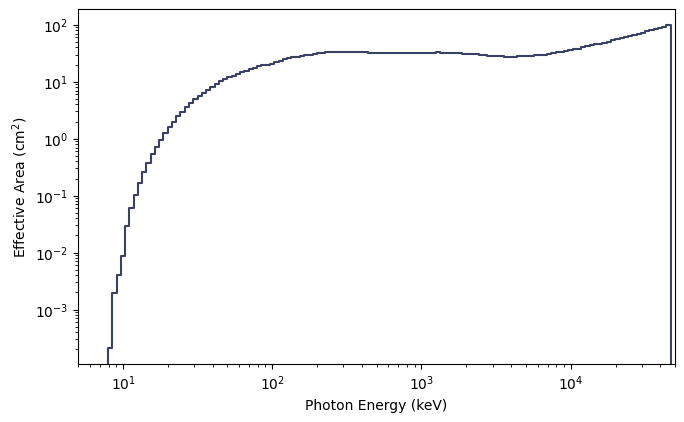

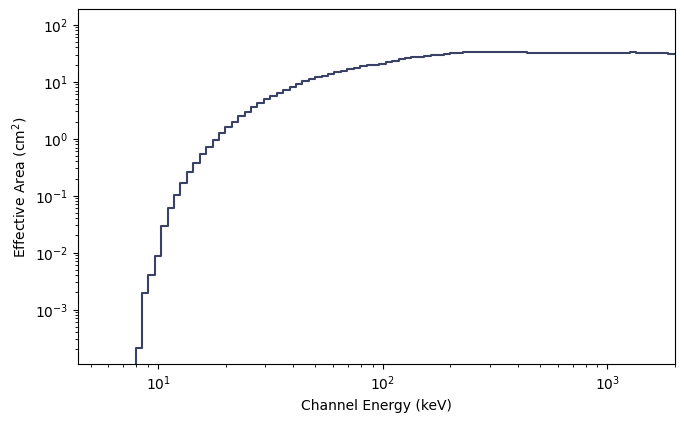

In [9]:
from gbm.plot import PhotonEffectiveArea, ChannelEffectiveArea

# plot the effective area of incident photons...
effarea_plot1 = PhotonEffectiveArea(data=rsp)

# ...and of the recorded counts
effarea_plot2 = ChannelEffectiveArea(data=rsp)

Alternatively, if you're interested in effective area at a particular energy (as long as it's within the bounds of the DRM), you can simply do the following:

In [10]:
# the effective area at 50 and 300 keV, respectively for the first DRM
rsp.effective_area((50.0, 300.0), index=0)

array([11.89553229, 32.67522618])

The thing we actually use the DRMs for is to fold a model photon spectrum through the response to get out a count spectrum.  That model count spectrum can then be compared to the observed count spectrum.  Here's a little example how you can fold a model (power law) through the response:

In [11]:
# a power-law function.  
# params is a list of parameters: (amplitude, index)
def powerlaw(params, energies):
    return params[0]*(energies/100.0)**params[1]

# fold a power law with amplitude 0.1 and index -2.0 through the DRM at trigger time
rsp.fold_spectrum(powerlaw, (0.1, -2.0), atime=0.0)

array([ 2.04555274,  2.41331594,  2.0801156 ,  1.56281085,  1.57124845,
        1.95612002,  2.18619054,  2.68707728,  3.09026986,  3.87129313,
        4.53683755,  5.03903868,  5.73969901,  6.52557411,  8.28145565,
        8.7270274 ,  9.29967452,  9.82871379, 10.27252461, 10.64788631,
       12.61452885, 13.15436336, 14.44362474, 11.80630877,  9.50993977,
       10.43132101, 10.1795827 , 10.10485369, 10.03455281, 11.04248059,
       10.96586462, 10.81956114, 10.62896509, 11.44405505, 11.17678178,
       10.83984442, 10.62419227, 11.19721732, 10.7731077 , 10.3303892 ,
       10.66799448, 10.10228782,  9.49523992,  9.61971953,  8.985341  ,
        8.39447276,  8.44452405,  7.92898771,  7.45480185,  7.48758995,
        7.10000065,  6.68551051,  6.72736702,  6.35803467,  6.3318537 ,
        5.9776809 ,  5.95175188,  5.5961889 ,  5.57163798,  5.23856799,
        4.92137297,  4.89368401,  4.59042939,  4.4728742 ,  4.40192887,
        4.11651911,  3.98410912,  3.73872024,  3.63021577,  3.34

And there you go, you have an array for the counts spectrum for a -2 power law folded through this detector!

You can also perform operations to modify the DRM.  Specifically, you can change the resolution of the photon energy axis of the DRM or adjust the photon bin edges:

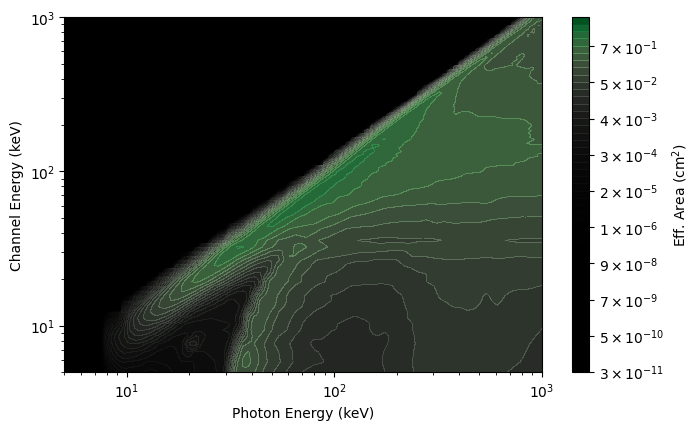

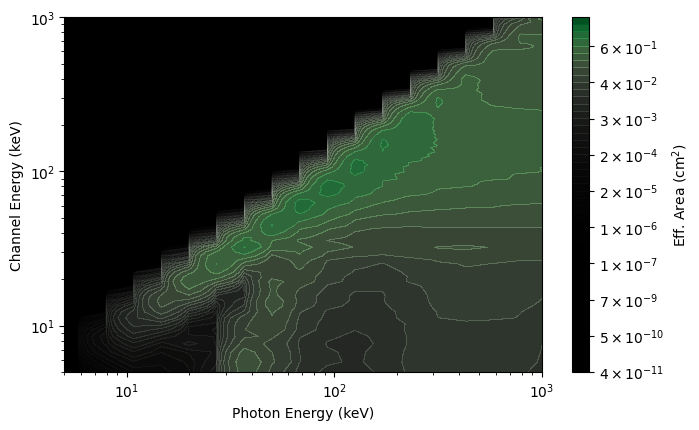

In [12]:
# increase the number of photon bins to 300 (instead of the nominal 140)
rsp_hires = rsp.resample(num_photon_bins=300, index=0)
rsp_plot_hires = ResponseMatrix(rsp_hires, num_contours=50)
rsp_plot_hires.xlim = (5.0, 1000.0)
rsp_plot_hires.ylim = (5.0, 1000.0)

# decrease the number of photon bins to 30
rsp_lores = rsp.resample(num_photon_bins=30, index=0)
rsp_plot_lores = ResponseMatrix(rsp_lores, num_contours=50)
rsp_plot_lores.xlim = (5.0, 1000.0)
rsp_plot_lores.ylim = (5.0, 1000.0)

While you cannot increase the resolution of the energy channel axis of the DRM, you can rebin that axis to a lower resolution:

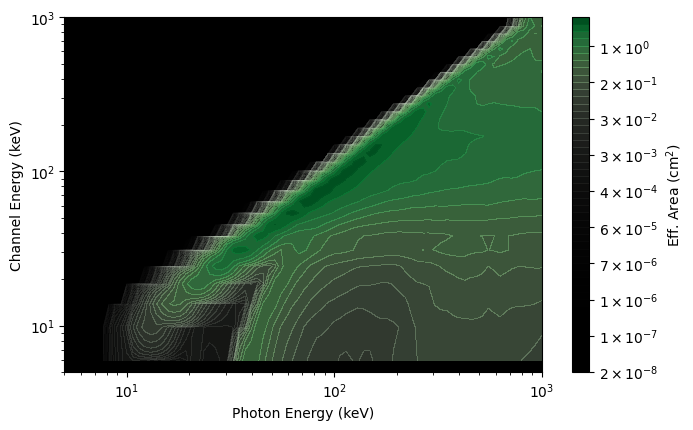

In [13]:
# rebin the energy channel axis by a factor of 4
rsp_rebinned = rsp.rebin(factor=4, index=0)
rsp_plot_rebinned = ResponseMatrix(rsp_rebinned, num_contours=50)
rsp_plot_rebinned.xlim = (5.0, 1000.0)
rsp_plot_rebinned.ylim = (5.0, 1000.0)

If you've followed along so far, you now have the ability to read the GBM primary science data and even apply the detector response for a source (albeit rudimentarily).  [Continue](./PositionHistory.ipynb) to learn about the most important GBM auxiliary data